# **TRABALHO 3** MapReduce Apache Spark - Cloud

* Antonia Raiane Santos Araujo Cruz
* Jerry Macedo

### **Contextualização**

As questões solicitadas estão apresetadas na sequência da especificação da tarefa. O relatório será feito também neste notebook, obedecendo a sequência dos itens, conforme solicitado: descrição do ambiente utilizado para execução das aplicações Hadoop/Spark; e cada item deve ser respondido e devidamente explicado como o resultado foi encontrado em um ou dois parágrafos;

> Os datasets poderão ser obtidos [Downlaod Datasets](https://drive.google.com/drive/mobile/folders/0BzwVBj1heLoReXVLaU51bTAxZ2M?usp=sharing)
* Link do vídeo: https://drive.google.com/file/d/17DT3KH2OA4rUm8CXgvgXE8NkUmYy33Ie/view?usp=sharing

### Descrição do ambiente

Incialmente utilizamos o Google Colaboratory, entretando após alguns erros em relação ao tratamento dos campos com datas, mudou-se os experimentos para outro ambiente. Inciou-se então os experimentos utilizando o Jupyter Notebook (com a instalação do Anaconda Navigator). Na sequência instalamos o `python3`, e o pacote `Pyshark` (Spark com Python) 3.3.1, (`spark-3.1.2-bin-hadoop2.7`) e o `java 8`. A máquina utilizada apresenta uma configuração de S.O Windows 10, 8 GB de RAM e disco SSD de 250 GB. 

### Instalando as dependências

O PySpark é uma biblioteca Spark escrita em Python para executar aplicativos Python usando os recursos do Apache Spark. Usando o PySpark podemos executar aplicativos paralelamente no cluster distribuído (em vários nós). O Apache Spark funciona em uma arquitetura master-slave onde o master é chamado de “Driver” e os slaves são chamados de “Workers”. Quando executamos um aplicativo Spark, o Spark Driver cria um contexto que é um ponto de entrada para seu aplicativo e todas as operações que serão executadas em nós de trabalho e os recursos são gerenciados pelo Cluster Manager.



> * **Driver Program**: é a aplicação principal que gerencia a criação e é quem executará o processamento definido.
> * **Cluster Manager**:  é um componente opcional que só é necessário se o Spark for executado de forma distribuída. Ele é responsável por administrar as máquinas que serão utilizadas como *workers*;
> * **Workers**: são as máquinas que realmente executarão as tarefas que são enviadas pelo Driver Program. Se o Spark for executado de forma local, a máquina desempenhará tanto o papel de Driver Program como de Worker.

In [464]:
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable


Após instalação, definimos as seguintes variáveis de ambiente.

In [659]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"   

Abaixo, são importadas as bibliotecas necessárias para a execução de algumas  das tarefas realizadas, como as bibliotecas para  criação da sessão, funções sql, types para a definimos do `schema`, funções para o timestamp e regex.

In [462]:
from pyspark.sql import SparkSession
from pyspark.sql.types import * 
from pyspark.sql.functions import *
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, udf, to_timestamp, hour,from_utc_timestamp, regexp_extract
from pyspark.sql.functions import to_timestamp
import matplotlib.pyplot as plt


Em seguida criou-se uma Sessão Spark, onde é possível configurar os nós do cluster, bem como a memória alocada para cada um deles. O Apache Spark fornece um conjunto de interfaces de usuário da Web (trabalhos, estágios, tarefas, armazenamento, ambiente, executores e SQL) para monitorar o status de seu aplicativo `Spark` , o consumo de recursos do cluster Spark e as configurações do Spark. No `Spark Web UI`, você pode ver como as operações são executadas.

In [543]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .appName("TrabalhoMapReduce") \
    .config('spark.ui.port', '4041') \
    .config("spark.memory.offHeap.enabled","true")\
     .config("spark.memory.offHeap.size","10g")\
    .getOrCreate()

In [473]:
spark

Para além da arquitetura do modelo de programação do Spark, também podemos definir os conceitos de `Resilient Distributed Datasets` (RDD) que são utilizados para abstrair um conjunto de objetos distribuídos no cluster, normalmente executados na memória principal. Representam a finalidade principal do modelo de programação do `Spark`, pois são nesses objetos que executa-se o processamento dos dados.

Outro aspecto importante são as `operações` que represetam  as transformações realizadas (como agrupamentos, filtros e mapeamentos entre os dados) ou `ações` (como contagens e persistências) que são realizados em um RDD. Já o `Spark Context` é o objeto que conecta o Spark ao programa que está sendo desenvolvido. No caso deste processamento, podemos acessar o Sparl Context pela variável `spark`, conforme célula acima.

In [476]:
get_ipython().system_raw('./ngrok authtoken 2IdsLU5nGafRfq650p5MAO8GJ1D_7qUYgZtkBw8QLPF25JaF4')
get_ipython().system_raw('./ngrok http 4050 &')

In [477]:
!curl -s http://localhost:4041/api/tunnels

## **Questões**


### Questão2) Dado um dataset com tweets relacionados à campanha eleitoral presidencial de 2014, responda:

Para o uso deste dataset foi utilizado a descrição do dataset conforme disponibilizadono link abaixo:
Descrição:
- debate-tweets.tsv: http://lia.ufc.br/~igobrilhante/twitter-home/
- eiffel-tower-reviews.json: Cada linha é um son com representação do review

Para o dataset utilizamos o `schema`conforme a descrição acima, através da estrutura `StructType`, definindo assim as `fields`que poderão ser acessadas posteriormente pela posição ou nome.

In [364]:
schemaDfDebate = StructType() \
      .add("id",LongType(),True) \
      .add("content",StringType(),True) \
      .add("coordinate_0",StringType(),True) \
      .add("coordiante_1",StringType(),True) \
      .add("retweeted",StringType(),True) \
      .add("tweet_id",StringType(),True) \
      .add("tweet_id_str",StringType(),True) \
      .add("created_at",StringType(),True) \
      .add("created_at_str",StringType(),True) \
      .add("in_reply_to_user_id",StringType(),True) \
      .add("lang",StringType(),True) \
      .add("place_name",StringType(),True) \
      .add("place_id",StringType(),True) \
      .add("place_bb_00",StringType(),True) \
      .add("place_bb_01",StringType(),True) \
      .add("place_bb_10",StringType(),True) \
      .add("place_bb_11",StringType(),True) \
      .add("place_bb_20",StringType(),True) \
      .add("place_bb_21",StringType(),True) \
      .add("place_bb_30",StringType(),True) \
      .add("place_bb_31",StringType(),True) \
      .add("place_type",StringType(),True) \
      .add("place_country_code",StringType(),True) \
      .add("place_country",StringType(),True) \
      .add("place_full_name",StringType(),True) \
      .add("user_name",StringType(),True) \
      .add("user_id",StringType(),True) \
      .add("user_id_str",StringType(),True) \
      .add("user_location",StringType(),True) \
      .add("user_friend_count",StringType(),True) \
      .add("user_created_at",StringType(),True) \
      .add("user_screen_name",StringType(),True) 


A seguir fazemos a leitura do dataset através da função `spark.read.csv`e tabulamos em seguida.

In [365]:
dfDebate = spark.read.csv("debate-tweets.tsv",sep=r'\t',schema=schemaDfDebate)
dfDebate.printSchema()

root
 |-- id: long (nullable = true)
 |-- content: string (nullable = true)
 |-- coordinate_0: string (nullable = true)
 |-- coordiante_1: string (nullable = true)
 |-- retweeted: string (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- tweet_id_str: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- created_at_str: string (nullable = true)
 |-- in_reply_to_user_id: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- place_name: string (nullable = true)
 |-- place_id: string (nullable = true)
 |-- place_bb_00: string (nullable = true)
 |-- place_bb_01: string (nullable = true)
 |-- place_bb_10: string (nullable = true)
 |-- place_bb_11: string (nullable = true)
 |-- place_bb_20: string (nullable = true)
 |-- place_bb_21: string (nullable = true)
 |-- place_bb_30: string (nullable = true)
 |-- place_bb_31: string (nullable = true)
 |-- place_type: string (nullable = true)
 |-- place_country_code: string (nullable = true)
 |-- place_country

In [323]:
dfDebate

DataFrame[id: bigint, content: string, coordinate_0: string, coordiante_1: string, retweeted: string, tweet_id: string, tweet_id_str: string, created_at: string, created_at_str: string, in_reply_to_user_id: string, lang: string, place_name: string, place_id: string, place_bb_00: string, place_bb_01: string, place_bb_10: string, place_bb_11: string, place_bb_20: string, place_bb_21: string, place_bb_30: string, place_bb_31: string, place_type: string, place_country_code: string, place_country: string, place_full_name: string, user_name: string, user_id: string, user_id_str: string, user_location: string, user_friend_count: string, user_created_at: string, user_screen_name: string]

Abaixo podemos visualizar o tipo de dados.

In [283]:
type(dfDebate)

pyspark.sql.dataframe.DataFrame

In [764]:
print("O número de linhas e colunas do DataFrame:", (dfDebate.count(), len(dfDebate.columns)))

O número de linhas e colunas do DataFrame: (7228127, 32)


In [285]:
dfDebate.take(2)

[Row(id=522394422710136832, content='@anacddd verdade, olha o site', coordinate_0='-27.516566', coordiante_1='-48.646082', retweeted='False', tweet_id='522394422710136832', tweet_id_str='522394422710136832', created_at='Wed Oct 15 14:31:50 +0000 2014', created_at_str='2014-10-15', in_reply_to_user_id='303425830', lang='pt', place_name='Biguaçu', place_id='77c15e08a456c529', place_bb_00='0.0', place_bb_01='0.0', place_bb_10='0.0', place_bb_11='0.0', place_bb_20='0.0', place_bb_21='0.0', place_bb_30='0.0', place_bb_31='0.0', place_type=None, place_country_code=None, place_country=None, place_full_name=None, user_name='Geovana Nunes', user_id='295414968', user_id_str='295414968', user_location=None, user_friend_count='316', user_created_at='Mon May 09 00:12:02 +0000 2011', user_screen_name='geovanannunes'),
 Row(id=522394422806581248, content='Que ñ*', coordinate_0='-27.768328', coordiante_1='-51.668323', retweeted='False', tweet_id='522394422806581248', tweet_id_str='522394422806581248',

In [286]:
dfDebate.limit(10).toPandas()

,id,content,coordinate_0,coordiante_1,retweeted,tweet_id,tweet_id_str,created_at,created_at_str,in_reply_to_user_id,...,place_country_code,place_country,place_full_name,user_name,user_id,user_id_str,user_location,user_friend_count,user_created_at,user_screen_name
0,522394422710136832,"@anacddd verdade, olha o site",-27.516566,-48.646082,False,522394422710136832,522394422710136832,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,303425830,...,None,None,None,Geovana Nunes,295414968,295414968,None,316,Mon May 09 00:12:02 +0000 2011,geovanannunes
1,522394422806581248,Que ñ*,-27.768328,-51.668323,False,522394422806581248,522394422806581248,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,None,...,None,None,None,Rosane Fernandes,2409363642,2409363642,Cacique Doble RS,47,Mon Mar 24 18:06:40 +0000 2014,Rosane_fsf
2,522394422731100160,Vou quebrar a Bruna,-27.00464,-48.623519,False,522394422731100160,522394422731100160,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,None,...,None,None,None,Bebel,162447082,162447082,None,513,Sat Jul 03 18:03:35 +0000 2010,_isarenata
3,522394422810783745,agora vou p segundo andar e depois p 3° 👏,-15.852082,-47.961413,False,522394422810783745,522394422810783745,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,None,...,None,None,None,tatá,387694391,387694391,None,347,Sun Oct 09 14:19:52 +0000 2011,thayflausino
4,522394423137943553,Me sinto tão bem - Mika #QueroNoTVZ,-3.755046,-38.566769,False,522394423137943553,522394423137943553,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,None,...,None,None,None,Simone ♥ DDM's ♥,152792963,152792963,Fortaleza/Ceará,719,Sun Jun 06 22:15:22 +0000 2010,simoneesilva
5,522394423188271104,"Eu estou aqui, deixando a vida me guiar, não é...",-22.846869,-43.30883,False,522394423188271104,522394423188271104,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,None,...,None,None,None,Gar6,749780077,749780077,Rio de Janeiro,356,Fri Aug 10 17:56:10 +0000 2012,juliagar6
6,522394423238606848,Quando vai embora tudo fica sem graça,-22.904301,-43.544403,False,522394423238606848,522394423238606848,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,None,...,None,None,None,Isa,2476253858,2476253858,None,164,Sun May 04 02:22:02 +0000 2014,isabelleecorrea
7,522394423528022016,@paynecaralhudo kkkkkk n n sou legal kkk,-23.509058,-46.96892,False,522394423528022016,522394423528022016,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,518826601,...,None,None,None,Júlio Lessa ✌,324937648,324937648,None,943,Mon Jun 27 13:28:08 +0000 2011,SiempreCtgLS
8,522394423632875521,Conceição da Barra acho que vou pra outro dia,-18.713338,-40.405779,False,522394423632875521,522394423632875521,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,None,...,None,None,None,♔Lu♔,536501962,536501962,Nova Venécia-Es,82,Sun Mar 25 17:45:22 +0000 2012,Hey_Marrenta
9,522394424010362881,@Maniavato te amo ♥,-23.064705,-45.717173,False,522394424010362881,522394424010362881,Wed Oct 15 14:31:50 +0000 2014,2014-10-15,542665678,...,None,None,None,queen,1414028317,1414028317,| no puteiro com a Ju. |,1911,Wed May 08 22:50:20 +0000 2013,ButeraCertified


Abaixo podemos visualizar 10 linhas com os tweets realizados.

In [766]:
dfDebate.select(dfDebate['content']).show(10,truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------+
|content                                                                                                                             |
+------------------------------------------------------------------------------------------------------------------------------------+
|@anacddd verdade, olha o site                                                                                                       |
|Que ñ*                                                                                                                              |
|Vou quebrar a Bruna                                                                                                                 |
|agora vou p segundo andar e depois p 3° 👏                                                                                          |
|Me sinto tão bem - Mika #QueroNoTVZ                    

In [324]:
dfDebate.select(dfDebate['user_created_at'], dfDebate['created_at']).show(5,truncate=False)

+------------------------------+------------------------------+
|user_created_at               |created_at                    |
+------------------------------+------------------------------+
|Mon May 09 00:12:02 +0000 2011|Wed Oct 15 14:31:50 +0000 2014|
|Mon Mar 24 18:06:40 +0000 2014|Wed Oct 15 14:31:50 +0000 2014|
|Sat Jul 03 18:03:35 +0000 2010|Wed Oct 15 14:31:50 +0000 2014|
|Sun Oct 09 14:19:52 +0000 2011|Wed Oct 15 14:31:50 +0000 2014|
|Sun Jun 06 22:15:22 +0000 2010|Wed Oct 15 14:31:50 +0000 2014|
+------------------------------+------------------------------+
only showing top 5 rows



### a) Quais foram as hashtags mais usadas pela manhã, tarde e noite?

Antes de executarmos, criarmos um filtro, incluimos uma configuração de valor padrão para `spark.sql.legacy.timeParserPolicy` que funcionará como uma `EXCEPTION` em que o Spark, em casos do não funcinamento de umas das funções de `timestamp`(unix_timestamp, from_unixtime, from_utc_timstamp, to_unix_timestamp, to_utc_timestamp) para a análise dos dados, então sugere-se uma conversão que poderá funcionar com `LEGACY` para o formato de data. 

In [691]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
dfDebateDate=dfDebate.withColumn("date",to_timestamp('created_at', 'EEE LLL d HH:mm:ss z yyyy'))
dfDebateFiltro=dfDebateDate.select('content','created_at',"date")

Após, criamos um filtro que levasse em consideração a função `rlike()` e definisse uma nova coluna, nomeada como *hashtag*, para o DataFrame a partir da uma coluna existente *content*, extraindo a hashtag a partir da combinação das expressões regulares `regexp_extract`, conforme investigado em links apresentados abaixo. Em seguida é mostrado o novo DataFrame `dfHashtag`.

> [Link 1](https://randlow.github.io/posts/nlp/nlp-regex/)  e 
> [Link 2](https://gist.github.com/mahmoud/237eb20108b5805aed5f)

In [389]:
dfHashtag=dfDebateFiltro.filter(dfDebateFiltro["content"].rlike("^#\w+|\s#\w+")).withColumn("hashtag",regexp_extract("content","^#\w+|\s#\w+",0))\
.withColumn("hora",hour("date"))
dfHashtag.show(5)

+--------------------+--------------------+-------------------+--------------------+----+
|             content|          created_at|               date|             hashtag|hora|
+--------------------+--------------------+-------------------+--------------------+----+
|Me sinto tão bem ...|Wed Oct 15 14:31:...|2014-10-15 11:31:50|         #QueroNoTVZ|  11|
|#EMABiggestFansJu...|Wed Oct 15 14:31:...|2014-10-15 11:31:50|#EMABiggestFansJu...|  11|
|Dr. Bieber #EMABi...|Wed Oct 15 14:31:...|2014-10-15 11:31:51| #EMABiggestFansJ...|  11|
|MIDNIGHT MEMORIES...|Wed Oct 15 14:31:...|2014-10-15 11:31:51|   #EMABiggestFans1D|  11|
|#EMABiggestFans1D...|Wed Oct 15 14:31:...|2014-10-15 11:31:52|   #EMABiggestFans1D|  11|
+--------------------+--------------------+-------------------+--------------------+----+
only showing top 5 rows



Depois disso, realizou-se um filtro considerando um intervalo de tempo para cada turno, manhã, tarde e noite. Considerando o período da manhã de *06h até as 12h*, período da tarde de *12h as 18h* e noite de *18h até as 6h* da manhã. Dividiu-se os resultados em duas partes, a contabilização das hashtags e visuzalização das mais usadas. Optou-se por apresentá-las listando um top 10 das hashtags mais usadas em cada turno. 

In [397]:
dfHashtag_manha=dfHashtag.filter((dfHashtag["hora"]>=6) & (dfHashtag["hora"]<12));
dfHashtag_manha.count()

118999

Desta forma, no período da manhã nota-se que foram twets com 118999 hashtags, sendo que desse valor optamos por apresentar um agrupamento de apenas as 10 hashtags mais usadas, utilizando a função `count()`,e o parâmetro `ascending=False` da função `sort()` limitando a 10. Conforme apresetnado na tabela abaixo:

In [770]:
print("Top 10 das hastags mais usadas pela manhã:")
dfHashtag_manha.groupby("hashtag", "hora").count().sort('count', ascending=False).limit(10).show()

Top 10 das hastags mais usadas pela manhã:
+--------------------+----+-----+
|             hashtag|hora|count|
+--------------------+----+-----+
|   #EMABiggestFans1D|  11| 9009|
| #EMABiggestFansJ...|  11| 7523|
|   #EMABiggestFans1D|  10| 6204|
| #EMABiggestFansJ...|  10| 5091|
|   #EMABiggestFans1D|   9| 4511|
| #EMABiggestFansJ...|   9| 4193|
|   #EMABiggestFans1D|   8| 3977|
| #EMABiggestFansJ...|   8| 2402|
|   #EMABiggestFans1D|   7| 2239|
| #EMABiggestFansJ...|   6| 1946|
+--------------------+----+-----+



Em relação ao período da tarde, observamos que foram tweetadas 267072 hashtags. De forma que já estão apresentadas de forma decrescente, conforme explicação acima. Nota-se que entre das 12h às 18h a hashtag mais usada foi a #EMABiggestFans1D.

In [392]:
dfHashtag_tarde=dfHashtag.filter((dfHashtag["hora"]>=12) & (dfHashtag["hora"]<18));
dfHashtag_tarde.count()

267072

Abaixo apresentamos o top 10 hashtags mais usadas à tarde. Com a mesma lógica da anterior.

In [393]:
print("Top 10 das hastags mais usas pela tarde:")
dfHashtag_tarde.groupby("hashtag").count().sort('count', ascending=False).limit(10).show()

Top 10 das hastags mais usas pela tarde:
+--------------------+-----+
|             hashtag|count|
+--------------------+-----+
|   #EMABiggestFans1D|57515|
| #EMABiggestFansJ...|52163|
|#EMABiggestFansJu...| 6057|
|        #StealMyGirl| 5918|
|   #EMABiggestFans1D| 4812|
|   #bigpaynodanceoff| 3649|
| #LuanSantanaNaHo...| 2872|
|    #CartersNewVideo| 1679|
|     #FlyNoMixDiario| 1141|
|       #AustinMahone| 1040|
+--------------------+-----+



Enquanto que à noite tivemos um total de 487219 hashtags, considerando o filtro de horário das *18h às 06h*. Logo em seguida visualizamos as 10 hashtgas mais tweetadas.

In [394]:
dfHashtag_noite=dfHashtag.filter(dfHashtag["hora"]>=18).union(dfHashtag.filter(dfHashtag["hora"]<6));
dfHashtag_noite.count()

487219

In [398]:
print("Top 10 das hastags mais usas pela noite:")
dfHashtag_noite.groupby("hashtag").count().sort('count', ascending=False).limit(10).show()

Top 10 das hastags mais usas pela noite:
+--------------------+------+
|             hashtag| count|
+--------------------+------+
| #EMABiggestFansJ...|104327|
|   #EMABiggestFans1D|104241|
|#EMABiggestFansJu...| 14142|
|       #camilasayshi|  9024|
|   #EMABiggestFans1D|  8587|
|     #TheVoiceBrasil|  2315|
|        #DebateNoSBT|  2229|
|                  #E|  2037|
|        #AssistamODR|  1953|
|          #Vote5HEMA|  1952|
+--------------------+------+



### b) Quais as hashtags mais usadas em cada dia?

A próxima questão busca as hashtags mais usadas em cada dia. Aqui optamos por paresentar de duas formas distintas. Primeiro, filtramos considerando o retorno da função `rlike("^#\w+|\s#\w+")`e as expressões regulares, extraindo a data em um formato de minutos, hora,dia, mês, dia da semana e a hashtag. Conforme os links referência abaixo:
> [Link 1](https://randlow.github.io/posts/nlp/nlp-regex/)  e 
> [Link 2](https://gist.github.com/mahmoud/237eb20108b5805aed5f)

In [497]:
dfHashtag_info_data=dfDebateDate.filter(dfDebateDate["content"].rlike("^#\w+|\s#\w+"))\
    .withColumn("minutos",F.minute("date"))\
    .withColumn("hora",F.hour("date"))\
    .withColumn("dia",F.dayofmonth("date"))\
    .withColumn("mês",F.month("date"))\
    .withColumn("diaSemana", F.date_format(col("date"), "E"))\
    .withColumn("hashtag",regexp_extract("content","^#\w+|\s#\w+",0)).select("dia","mês","hora", "minutos","diaSemana","hashtag", "content");
dfHashtag_info_data

DataFrame[dia: int, mês: int, hora: int, minutos: int, diaSemana: string, hashtag: string, content: string]

In [400]:
dfHashtag_info_data

DataFrame[dia: int, mês: int, hora: int, minutos: int, hashtag: string]

Em seguida, realizou-se um `groupby()` do *dia, mês e hashtag*. Apresenta-se os resultados após o uso da função `count()`de forma  decrescente com a função `sort()`. A tabela é apresentada utilizando o `toPandas()`e considerando o dia e mês. Entretanto não utilizou-se um limite para a listagem. Nota-se que a hashtag #EMABiggestFans1D foi a mais utilizada no dia 16 do mês 10.

In [403]:
dfHashtag_dia_final=dfHashtag_info_data.groupby("dia","mês","hashtag").count().sort("count", ascending=False)
print("As hastags mais usadas por dia:")
dfHashtag_dia_final.toPandas()

As hastags mais usadas por dia:


,dia,mês,hashtag,count
0,16.0,10.0,#EMABiggestFans1D,58662
1,16.0,10.0,#EMABiggestFansJustinBieber,46097
2,15.0,10.0,#EMABiggestFans1D,43730
3,15.0,10.0,#EMABiggestFansJustinBieber,40738
4,17.0,10.0,#EMABiggestFans1D,32530
...,...,...,...,...
148127,20.0,10.0,#Tw10000,1
148128,20.0,10.0,#arisjerome,1
148129,20.0,10.0,#TeAmoooo,1
148130,20.0,10.0,#primogato,1


Abaixo observa-se apenas a lista com as 40 hashtags mais usadas por dia. 

In [664]:
dfHashtag_dia_final=dfHashtag_info_data.groupby("dia","mês","hashtag").count().sort("count", ascending=False)
print("As hastags mais usadas por dia:")
dfHashtag_dia_final.limit(40).toPandas()

As hastags mais usadas por dia:


,dia,mês,hashtag,count
0,16,10,#EMABiggestFans1D,58662
1,16,10,#EMABiggestFansJustinBieber,46097
2,15,10,#EMABiggestFans1D,43730
3,15,10,#EMABiggestFansJustinBieber,40738
4,17,10,#EMABiggestFans1D,32530
5,17,10,#EMABiggestFansJustinBieber,31609
6,19,10,#EMABiggestFansJustinBieber,28989
7,18,10,#EMABiggestFansJustinBieber,27834
8,18,10,#EMABiggestFans1D,26095
9,19,10,#EMABiggestFans1D,25884


### c) Qual o número de tweets por hora a cada dia? 

Coma mesma lógica da questão anterior, observa-se que para retornar o número de tweets por hora a cada dia, realizou-se um `groupby()` do *dia e hora* a fim de obter um r esultado do número de tweets com a  função `count()`de forma decrescente com a função `sort()`. A tabela é apresentada utilizando o `toPandas()`e considerando o dia e hora. 

In [667]:
dfHashtag_hora_final=dfHashtag_info_data.groupBy("dia","hora").count().sort("count", ascending=False)
print("O número de tweets por hora a cada dia:")
dfHashtag_hora_final.limit(10).toPandas()

O número de tweets por hora a cada dia:


,dia,hora,count
0,15,22,36056
1,15,23,23763
2,16,22,22473
3,16,23,20955
4,17,0,16133
5,16,18,15622
6,16,19,15379
7,16,0,15255
8,15,20,14740
9,15,15,14513


In [682]:
df=dfHashtag_info_data.filter((dfHashtag_info_data["hora"]==22) & (dfHashtag_info_data["dia"]==15)).show()

36056

In [684]:
df.groupby("hora","dia").count().sort('count', ascending=False).limit(10).show()

+----+---+-----+
|hora|dia|count|
+----+---+-----+
|  22| 15|36056|
+----+---+-----+



In [669]:
dfHashtag_hora_final=dfHashtag_info_data.groupBy("hora","dia").count().sort("count", ascending=False)
print("O número de tweets por hora a cada dia:")
dfHashtag_hora_final.limit(10).toPandas()

O número de tweets por hora a cada dia:


,hora,dia,count
0,22,15,36056
1,23,15,23763
2,22,16,22473
3,23,16,20955
4,0,17,16133
5,18,16,15622
6,19,16,15379
7,0,16,15255
8,20,15,14740
9,15,15,14513


Abaixo utiliza-se um `groupBy` para resgatar a coluna *diaSemana* convertida anteriormente através da  conversão de *date* para *string* com a função `date_format(col("date"), "E"))` para apresentar o dia da semana. 

In [670]:
dfHashtag_hora_final=dfHashtag_info_data.groupBy("diaSemana","mês","hora").count().sort("count", ascending=False)
print("")
dfHashtag_hora_final.limit(10).toPandas()

,diaSemana,mês,hora,count
0,Wed,10,22,36056
1,Wed,10,23,23763
2,Thu,10,22,22473
3,Thu,10,23,20955
4,Fri,10,0,16133
5,Thu,10,18,15622
6,Thu,10,19,15379
7,Thu,10,0,15255
8,Wed,10,20,14740
9,Wed,10,15,14513


In [685]:
dfHashtag_hora_final=dfHashtag_info_data.groupBy("dia","hora","content").count().sort("count", ascending=False)
dfHashtag_hora_final.toPandas()

,dia,hora,content,count
0,15.0,22.0,#EMABiggestFansJustinBieber,112
1,15.0,23.0,MTV EMA | Vote - http://t.co/Ro4Y4aXn5A #EMABi...,100
2,16.0,0.0,MTV EMA | Vote - http://t.co/XUIMfCFG2L #EMABi...,93
3,16.0,22.0,#EMABiggestFansJustinBieber,63
4,15.0,23.0,#EMABiggestFansJustinBieber,57
...,...,...,...,...
848939,20.0,2.0,O povo da minha sala me odeia 😂 #EMABiggestFan...,1
848940,20.0,3.0,#brotherlylove #puggles and #george #puppies #...,1
848941,20.0,4.0,#Top3Apps for 'Luan e Letícia' Twitter for An...,1
848942,20.0,4.0,cento e noventa e dois #EMABiggestFansJustinBi...,1


### d) Quais as principais sentenças relacionadas à palavra “Dilma”?

A fim de indentificar em quais tweets a palavra *Dilma*  está relacionada, realizou-se um filtro que contenha a palavra *dilma* obedecendo o método de tratamento de strings `lower()`. Em seguida selecionamos apenas as 10 principais sentenças  relacionadas com a palvra Dilma.

In [697]:
dfDebateDilma=dfDebateDate.filter(lower(dfDebateDate["content"]).contains("dilma"))\
.groupBy("content").count().sort("count",ascending=False)
dfDebateDilma.toPandas()

,content,count
0,#QueroDilmaTreze,110
1,#MelhorcomDilma13,34
2,#MenosOdioMaisDilma,29
3,#Dilma13,24
4,#dilmavaiperderaecio45vencer,24
...,...,...
36216,"Por que o PT é perverso, segundo o Aécio? Se e...",1
36217,1. #MadrugadaDoSdvComTiuMarkito 2. #QueroDilma...,1
36218,@cristilobo @Fabio_Lemos55 Mas ela não consegu...,1
36219,Fora tucanos! PT mais quatro anos! #souDilma13...,1


In [424]:
print("Top 10 sentenças relacionadas à palavra Dilma:")
dfDebateDilma.limit(10).toPandas()

Top 10 sentenças relacionadas à palavra Dilma:


,content,count
0,#QueroDilmaTreze,110
1,#MelhorcomDilma13,34
2,#MenosOdioMaisDilma,29
3,#dilmavaiperderaecio45vencer,24
4,#Dilma13,24
5,#VouComDilma13,24
6,#DilmaTheVodka,21
7,#QueroDilma13,15
8,#Dilma13PraVencer,13
9,Dilma 13,7


### e) Quais as principais sentenças relacionadas à palavra “Aécio”?

Para esta questão utilizamos a mesma lógica da questão anterior, entretanto, analisando a possibilidade da palavra Aécio vir acetuada, optou-se por buscar resultados para aecio e aécio, agrupando os resultados.

In [705]:
#dfHashtag_noite=dfHashtag.filter(dfHashtag["hora"]>=18).union(dfHashtag.filter(dfHashtag["hora"]<6));dfHashtag_noite.count()

In [760]:
dfDebateAecio=dfDebateDate.filter(lower(dfDebateDate["content"]).contains("aécio"))\
    .union(dfDebateDate.filter(lower(dfDebateDate["content"]).contains("aecio")))\
    .groupBy("content").count().sort("count",ascending=False)
print("Top 10 sentenças relacionadas à palavra Aécio/Aecio:")
dfDebateAecio.limit(10).toPandas()

Top 10 sentenças relacionadas à palavra Aécio/Aecio:


,content,count
0,#AecioEmTodoBrasil,54
1,#EmTodoBrasilAecio45,49
2,#dilmavaiperderaecio45vencer,24
3,#AecioPelaMudanca,22
4,#Aecio45,16
5,#AgoraÉAecioBrasil,16
6,#AgoraEAecioBrasil,16
7,#AecioNever,13
8,@AecioNeves #EmTodoBrasilAecio45,12
9,@AecioNeves,11


### Questão 3) Dado um dataset com tweets relacionados à visita da Torre Eiffel em Paris, responda:

In [812]:
sc=spark.sparkContext

In [813]:
spark.sparkContext

<SparkContext master=local[*] appName=TrabalhoMapReduce>

Iniciamos lendo o conjunto de dados em `.json` e apresentando as colunas no dataFrame.

In [814]:
dfEiffel = spark.read.json("eiffel-tower-reviews.json")
dfEiffel.columns

['_id',
 'author',
 'bubbleCount',
 'collectedAt',
 'createdAt',
 'query',
 'text',
 'title']

In [438]:
dfEiffel.toPandas()

,_id,author,bubbleCount,collectedAt,createdAt,query,text,title
0,"(5921cdae4b679c4646a52f57,)","(0, 0, Since this month, 0, 0, 2)",50,"(2017-05-21T17:26:06.452Z,)","May 20, 2017",Eiffel_Tower,This is the most busiest atttaction in Paris a...,Must do even it was so busy
1,"(5921cdae4b679c4646a52f58,)","(10, 4, Since Aug 2015, 0, 23, 27)",50,"(2017-05-21T17:26:06.590Z,)","May 20, 2017",Eiffel_Tower,My significant other and I drunkenly stumbled ...,A Classic
2,"(5921cdae4b679c4646a52f59,)","(9, 4, Since Nov 2015, 0, 0, 31)",50,"(2017-05-21T17:26:06.642Z,)","May 20, 2017",Eiffel_Tower,We had a tour to the Eiffel Tower while we wer...,Wet weather
3,"(5921cdae4b679c4646a52f5a,)","(16, 5, Since Apr 2008, 0, 536, 37)",50,"(2017-05-21T17:26:06.721Z,)","May 20, 2017",Eiffel_Tower,Visited with my wife and son.,Not to be missed
4,"(5921cdae4b679c4646a52f5b,)","(30, 6, Since Jan 2014, 0, 36, 181)",50,"(2017-05-21T17:26:06.757Z,)","May 20, 2017",Eiffel_Tower,We went in the night at 10pm to see the illumi...,Awesome!!!
...,...,...,...,...,...,...,...,...
7174,"(59226b566af3a1312785d4f3,)","(0, 0, Since Jul 2015, 0, 0, 2)",30,"(2017-05-22T04:38:46.565Z,)","July 27, 2015",Eiffel_Tower,We recently visited the Eiffel Tower on our tr...,Tour me Eiffel
7175,"(59226b566af3a1312785d4f4,)","(13, 4, Since May 2009, 0, 15, 31)",40,"(2017-05-22T04:38:46.712Z,)","July 27, 2015",Eiffel_Tower,Getting through the lines is impossible or at ...,Bucket list must see
7176,"(59226b566af3a1312785d4f5,)","(47, 5, Since Oct 2010, 0, 1, 76)",50,"(2017-05-22T04:38:46.854Z,)","July 27, 2015",Eiffel_Tower,One must not be there to be served and one wil...,Crowded with awful staff. But who cares? It's ...
7177,"(59226b566af3a1312785d4f6,)","(0, 2, Since Aug 2012, 0, 0, 6)",50,"(2017-05-22T04:38:46.947Z,)","July 27, 2015",Eiffel_Tower,Loved the Eiffel tower this was my 2nd visit a...,AMAZING


In [439]:
print('Número de linhas no arquivo: %s' % dfEiffel.count())

Número de linhas no arquivo: 7179


### a) Encontre as palavras mais utilizadas nas avaliações.

Incialmente convertemos a coluna createdAt  através da função `to_date` e criamos uma nova coluna chamada *date* com a notação `MMM d,yyyy`.

In [815]:
dfEiffelDate=dfEiffel.withColumn("date",to_date('createdAt', 'MMM d,yyyy'))
dfEiffelDate.toPandas()

,_id,author,bubbleCount,collectedAt,createdAt,query,text,title,date
0,"(5921cdae4b679c4646a52f57,)","(0, 0, Since this month, 0, 0, 2)",50,"(2017-05-21T17:26:06.452Z,)","May 20, 2017",Eiffel_Tower,This is the most busiest atttaction in Paris a...,Must do even it was so busy,2017-05-20
1,"(5921cdae4b679c4646a52f58,)","(10, 4, Since Aug 2015, 0, 23, 27)",50,"(2017-05-21T17:26:06.590Z,)","May 20, 2017",Eiffel_Tower,My significant other and I drunkenly stumbled ...,A Classic,2017-05-20
2,"(5921cdae4b679c4646a52f59,)","(9, 4, Since Nov 2015, 0, 0, 31)",50,"(2017-05-21T17:26:06.642Z,)","May 20, 2017",Eiffel_Tower,We had a tour to the Eiffel Tower while we wer...,Wet weather,2017-05-20
3,"(5921cdae4b679c4646a52f5a,)","(16, 5, Since Apr 2008, 0, 536, 37)",50,"(2017-05-21T17:26:06.721Z,)","May 20, 2017",Eiffel_Tower,Visited with my wife and son.,Not to be missed,2017-05-20
4,"(5921cdae4b679c4646a52f5b,)","(30, 6, Since Jan 2014, 0, 36, 181)",50,"(2017-05-21T17:26:06.757Z,)","May 20, 2017",Eiffel_Tower,We went in the night at 10pm to see the illumi...,Awesome!!!,2017-05-20
...,...,...,...,...,...,...,...,...,...
7174,"(59226b566af3a1312785d4f3,)","(0, 0, Since Jul 2015, 0, 0, 2)",30,"(2017-05-22T04:38:46.565Z,)","July 27, 2015",Eiffel_Tower,We recently visited the Eiffel Tower on our tr...,Tour me Eiffel,2015-07-27
7175,"(59226b566af3a1312785d4f4,)","(13, 4, Since May 2009, 0, 15, 31)",40,"(2017-05-22T04:38:46.712Z,)","July 27, 2015",Eiffel_Tower,Getting through the lines is impossible or at ...,Bucket list must see,2015-07-27
7176,"(59226b566af3a1312785d4f5,)","(47, 5, Since Oct 2010, 0, 1, 76)",50,"(2017-05-22T04:38:46.854Z,)","July 27, 2015",Eiffel_Tower,One must not be there to be served and one wil...,Crowded with awful staff. But who cares? It's ...,2015-07-27
7177,"(59226b566af3a1312785d4f6,)","(0, 2, Since Aug 2012, 0, 0, 6)",50,"(2017-05-22T04:38:46.947Z,)","July 27, 2015",Eiffel_Tower,Loved the Eiffel tower this was my 2nd visit a...,AMAZING,2015-07-27


Em seguida, optamos por analisar criar um novo DataFrame com o `select` filtrando apenas a coluna *text*, que de certa forma seria a importante para esta questão. Aqui nota-se que numa análise inicial as famosas Stopwords (palavras que podem ser consideradas irrelevantes para o conjunto de resultados a ser exibido em uma busca realizada em uma Search Engine) certamente serão apresentadas como as palavras mais utilizadas, de modo que numa segunda análise talvez seja importante tentar removê-las e analisar as demais.. 

In [775]:
dfEiffelFiltro = dfEiffel.select('text')
dfEiffelFiltro.show()

+--------------------+
|                text|
+--------------------+
|This is the most ...|
|My significant ot...|
|We had a tour to ...|
|Visited with my w...|
|We went in the ni...|
|Dont hesitate and...|
|I enjoyed the tow...|
|Read through the ...|
|This by far was o...|
|Something you hav...|
|The views are bea...|
|Worth spending a ...|
|Took the tour to ...|
|A fantastic fusio...|
|Whatever you do i...|
|Not to miss..beau...|
|We visited in the...|
|Go for sunset and...|
|We booked weeks a...|
|Eiffel Tower is j...|
+--------------------+
only showing top 20 rows



Entretanto, ainda observando a primeira análise, realizamos um `select` para obter as colunas a partir da divisão do texto em várias colunas por meio do `split` na coluna *text*. Emseguida ordena-se o resultador de forma  decrescente e considerando a condição de serem diferentes de " ", conforma função `where('text != " "')`. Com isso, evidencia o que foi dito acima, as topwords estiveram em maior evidencia. 

In [724]:
(dfEiffelFiltro.select(explode(split(dfEiffelFiltro.text, ' ')).alias("text"))
       .where('text != " "').groupby("text").count().orderBy("count",ascending=False).select("text","count"))\
       .show()

+------+-----+
|  text|count|
+------+-----+
|   the|26696|
|    to|14756|
|   and|10980|
|     a| 8509|
|    of| 6912|
|    in| 5771|
|    is| 5735|
|   you| 5237|
|   was| 4950|
|    it| 4923|
|     I| 3944|
|   for| 3626|
|    at| 3524|
|Eiffel| 3090|
|    up| 3057|
|    we| 3016|
|    on| 2968|
|   The| 2793|
|   but| 2778|
|    We| 2758|
+------+-----+
only showing top 20 rows



In [725]:
dfEiffelFiltro.withColumn('text', F.explode(F.split(F.col('text'), ' '))) \
  .groupBy('text') \
  .count() \
  .sort('count', ascending=False) \
  .show()

+------+-----+
|  text|count|
+------+-----+
|   the|26696|
|    to|14756|
|   and|10980|
|     a| 8509|
|    of| 6912|
|    in| 5771|
|    is| 5735|
|   you| 5237|
|   was| 4950|
|    it| 4923|
|     I| 3944|
|   for| 3626|
|    at| 3524|
|Eiffel| 3090|
|    up| 3057|
|    we| 3016|
|    on| 2968|
|   The| 2793|
|   but| 2778|
|    We| 2758|
+------+-----+
only showing top 20 rows



Em relação a eliminação das stopwords, optamos a penas por apresentar um tokenizador com a divisão do texto e as palavras stopwrods.

In [726]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="text", outputCol="text_token")
tokenized = tokenizer.transform(dfEiffelFiltro)
print('############ Tokenized data extract:')
tokenized.show()


############ Tokenized data extract:
+--------------------+--------------------+
|                text|          text_token|
+--------------------+--------------------+
|This is the most ...|[this, is, the, m...|
|My significant ot...|[my, significant,...|
|We had a tour to ...|[we, had, a, tour...|
|Visited with my w...|[visited, with, m...|
|We went in the ni...|[we, went, in, th...|
|Dont hesitate and...|[dont, hesitate, ...|
|I enjoyed the tow...|[i, enjoyed, the,...|
|Read through the ...|[read, through, t...|
|This by far was o...|[this, by, far, w...|
|Something you hav...|[something, you, ...|
|The views are bea...|[the, views, are,...|
|Worth spending a ...|[worth, spending,...|
|Took the tour to ...|[took, the, tour,...|
|A fantastic fusio...|[a, fantastic, fu...|
|Whatever you do i...|[whatever, you, d...|
|Not to miss..beau...|[not, to, miss..b...|
|We visited in the...|[we, visited, in,...|
|Go for sunset and...|[go, for, sunset,...|
|We booked weeks a...|[we, booked, week

In [737]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [738]:
transformed_string=dfEiffelFiltroClean.replace(", ","")
print("Transformed String is:")
print(transformed_string)
transformed_string.show()

Transformed String is:
DataFrame[text_clean: array<string>]
+--------------------+
|          text_clean|
+--------------------+
|[busiest, atttact...|
|[significant, dru...|
|[tour, eiffel, to...|
|[visited, wife, s...|
|[went, night, 10p...|
|[dont, hesitate, ...|
|[enjoyed, tower, ...|
|[read, history, e...|
|[far, favourite, ...|
|[something, visit...|
|[views, beautiful...|
|[worth, spending,...|
|[took, tour, top,...|
|[fantastic, fusio...|
|[whatever, afford...|
|[miss..beautiful,...|
|[visited, afterno...|
|[go, sunset, stay...|
|[booked, weeks, a...|
|[eiffel, tower, l...|
+--------------------+
only showing top 20 rows



### b) Encontre as expressões mais usadas. Considere uma expressão um conjunto de palavras na sequencia. O tamanho da sequencia pode ser determinado por você.

A questão que segue sugere obtermos as expressões mais utilizadas, de forma que aqui é necessário utilizarmos a funçãõ `NGram`, um transformador de recursos que converte uma coluna de entrada de strings em uma matriz de n-gramas. Neste caso, valores nulos da matriz de entrada são ignorados. A partir disso, ele retorna uma matriz de n-gramas em que cada n-grama é representado por uma sequência de palavras separadas por espaço. 

In [823]:
from pyspark.ml.feature import NGram
dfEiffelExpressoes=dfEiffelFiltro.withColumn("expressoes",sentences("text"))\
    .select("expressoes")\
    .withColumn("expressoesUsadas",explode("expressoes")).select("expressoesUsadas")
dfEiffelExpressoes.show()

+--------------------+
|    expressoesUsadas|
+--------------------+
|[This, is, the, m...|
|[My, significant,...|
|[For, a, cliche, ...|
|[We, popped, in, ...|
|[The, view, from,...|
|[Definitely, cold...|
|[We, had, a, tour...|
|[Unfortunately, o...|
|[Visited, with, m...|
|[We, went, in, th...|
|[It, was, very, v...|
|[At, 10pm, there,...|
|[Its, like, milli...|
|[Covering, the, e...|
|[I, was, awe, stu...|
|    [Must, must, go]|
|[Dont, hesitate, ...|
|[The, view, is, i...|
|[Be, early, in, t...|
|[Make, sure, to, ...|
+--------------------+
only showing top 20 rows



In [821]:
ngram=NGram(n=3,inputCol="expressoesUsadas", outputCol="ngrams")

dfEiffelExpressoes=ngram.transform(dfEiffelExpressoes)\
    .withColumn("expressoesUsadas",explode("ngrams"))\
    .groupBy("expressoesUsadas").count().sort("count",ascending=False).select("expressoesUsadas","count")
print("Top 10 expressões mais usadas:")
dfEiffelExpressoes.limit(10).toPandas()

Top 10 expressões mais usadas:


,expressoesUsadas,count
0,the Eiffel Tower,1655
1,to the top,1377
2,of the tower,489
3,go to the,453
4,to go up,447
5,up to the,418
6,Eiffel Tower is,392
7,from the top,362
8,to see the,351
9,to go to,349


### c) Encontre os principais tópicos relacionados às revisões.

Para este item consideramos remover as stopwords e obter apenas as palavras de maior relevância.

In [742]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Raiane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [743]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [754]:
(dfEiffelFiltro.withColumn(explode(split(dfEiffelFiltro.text, ' ')).alias("text"))
       .where('text != " "').groupby("text").count().orderBy("count",ascending=False).select("text","count"))\
        .filter(~(col("text")).isin(stopwords))\
       .show()

+-------+-----+
|   text|count|
+-------+-----+
|      I| 3944|
| Eiffel| 3090|
|    The| 2793|
|     We| 2758|
|     go| 2423|
|  tower| 2320|
|    see| 1947|
|  Paris| 1887|
|  Tower| 1862|
|    top| 1854|
|    get| 1752|
|   time| 1655|
|   view| 1545|
|     It| 1454|
|  visit| 1293|
|       | 1261|
|tickets| 1203|
|  views| 1175|
|  worth| 1092|
|  night| 1088|
+-------+-----+
only showing top 20 rows



In [756]:
dfEiffelTopics=dfEiffelFiltro.withColumn("texts",split('text', ' '))\
    .withColumn('text', explode('texts')).select("text")\
    .withColumn("textTopics",lower(col("text"))).select("text","textTopics")\
    .filter(~(col("textTopics")).isin(stopwords))\
    .groupBy("textTopics").count().orderBy("count",ascending=False).select("textTopics","count")

dfEiffelTopics.limit(10).toPandas()


,textTopics,count
0,tower,4184
1,eiffel,3246
2,go,2594
3,paris,1997
4,see,1973
5,top,1876
6,get,1833
7,time,1661
8,view,1581
9,visit,1322


### d) Mapeie a distribuição temporal das revisões.

O mapeamento temporal das revisoes foi plotada em um gráfico  abaixo onde é possível observar a distribuição de revisões em relação ao tempo. Utilizou-se um `groupBy`.

In [829]:
dfEiffelDate.show()

+--------------------+--------------------+-----------+--------------------+------------+------------+--------------------+--------------------+----------+
|                 _id|              author|bubbleCount|         collectedAt|   createdAt|       query|                text|               title|      date|
+--------------------+--------------------+-----------+--------------------+------------+------------+--------------------+--------------------+----------+
|{5921cdae4b679c46...|{0, 0, Since this...|         50|{2017-05-21T17:26...|May 20, 2017|Eiffel_Tower|This is the most ...|Must do even it w...|2017-05-20|
|{5921cdae4b679c46...|{10, 4, Since Aug...|         50|{2017-05-21T17:26...|May 20, 2017|Eiffel_Tower|My significant ot...|           A Classic|2017-05-20|
|{5921cdae4b679c46...|{9, 4, Since Nov ...|         50|{2017-05-21T17:26...|May 20, 2017|Eiffel_Tower|We had a tour to ...|         Wet weather|2017-05-20|
|{5921cdae4b679c46...|{16, 5, Since Apr...|         50|{2017-05-

Text(0.5, 38.00000000000001, 'Data')

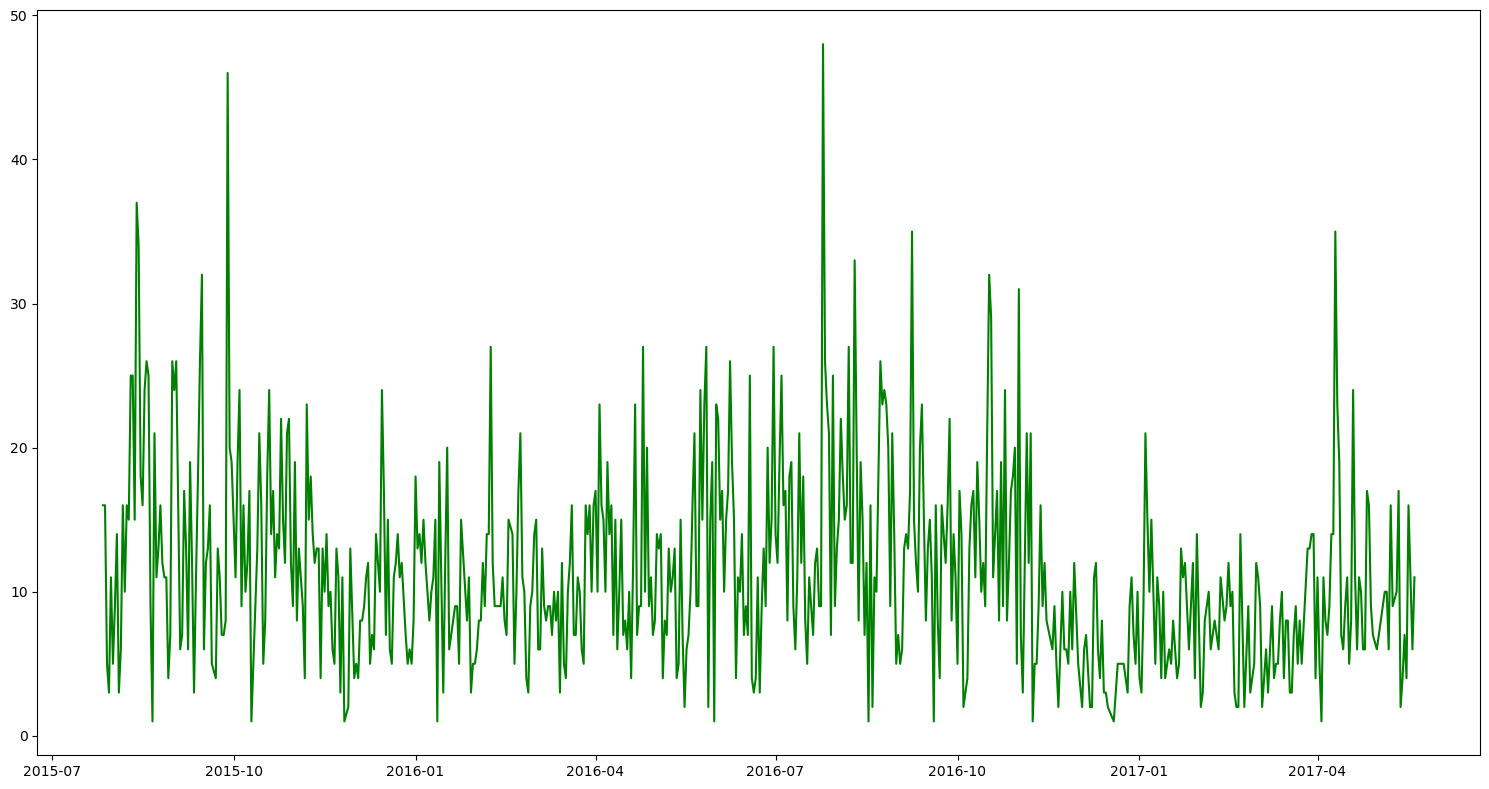

In [828]:
fig = plt.figure(figsize=(15,8))
plt.rcParams["figure.autolayout"] = True
#eixo = fig.add_axes([0, 0, 1, 1])
dfEiffelDistr=dfEiffelDate.groupby("date").count().sort("date").toPandas()
plt.plot(dfEiffelDistr["date"], dfEiffelDistr["count"], color= 'green')

eixo.set_title('Distribuição Temporal', fontsize=20)
eixo.set_ylabel('Revisões', fontsize=20)
eixo.set_xlabel('Data', fontsize=20)

In [834]:
dfEiffelDate_info_data=dfEiffelDate.withColumn("minutos",F.minute("date"))\
    .withColumn("hora",F.hour("date"))\
    .withColumn("dia",F.dayofmonth("date"))\
    .withColumn("mês",F.month("date"))\
    .withColumn("diaSemana", F.date_format(col("date"), "E"))\
    .withColumn("ano", F.year ("date"))
dfEiffelDate_info_data.toPandas()

,_id,author,bubbleCount,collectedAt,createdAt,query,text,title,date,minutos,hora,dia,mês,diaSemana,ano
0,"(5921cdae4b679c4646a52f57,)","(0, 0, Since this month, 0, 0, 2)",50,"(2017-05-21T17:26:06.452Z,)","May 20, 2017",Eiffel_Tower,This is the most busiest atttaction in Paris a...,Must do even it was so busy,2017-05-20,0,0,20,5,Sat,2017
1,"(5921cdae4b679c4646a52f58,)","(10, 4, Since Aug 2015, 0, 23, 27)",50,"(2017-05-21T17:26:06.590Z,)","May 20, 2017",Eiffel_Tower,My significant other and I drunkenly stumbled ...,A Classic,2017-05-20,0,0,20,5,Sat,2017
2,"(5921cdae4b679c4646a52f59,)","(9, 4, Since Nov 2015, 0, 0, 31)",50,"(2017-05-21T17:26:06.642Z,)","May 20, 2017",Eiffel_Tower,We had a tour to the Eiffel Tower while we wer...,Wet weather,2017-05-20,0,0,20,5,Sat,2017
3,"(5921cdae4b679c4646a52f5a,)","(16, 5, Since Apr 2008, 0, 536, 37)",50,"(2017-05-21T17:26:06.721Z,)","May 20, 2017",Eiffel_Tower,Visited with my wife and son.,Not to be missed,2017-05-20,0,0,20,5,Sat,2017
4,"(5921cdae4b679c4646a52f5b,)","(30, 6, Since Jan 2014, 0, 36, 181)",50,"(2017-05-21T17:26:06.757Z,)","May 20, 2017",Eiffel_Tower,We went in the night at 10pm to see the illumi...,Awesome!!!,2017-05-20,0,0,20,5,Sat,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7174,"(59226b566af3a1312785d4f3,)","(0, 0, Since Jul 2015, 0, 0, 2)",30,"(2017-05-22T04:38:46.565Z,)","July 27, 2015",Eiffel_Tower,We recently visited the Eiffel Tower on our tr...,Tour me Eiffel,2015-07-27,0,0,27,7,Mon,2015
7175,"(59226b566af3a1312785d4f4,)","(13, 4, Since May 2009, 0, 15, 31)",40,"(2017-05-22T04:38:46.712Z,)","July 27, 2015",Eiffel_Tower,Getting through the lines is impossible or at ...,Bucket list must see,2015-07-27,0,0,27,7,Mon,2015
7176,"(59226b566af3a1312785d4f5,)","(47, 5, Since Oct 2010, 0, 1, 76)",50,"(2017-05-22T04:38:46.854Z,)","July 27, 2015",Eiffel_Tower,One must not be there to be served and one wil...,Crowded with awful staff. But who cares? It's ...,2015-07-27,0,0,27,7,Mon,2015
7177,"(59226b566af3a1312785d4f6,)","(0, 2, Since Aug 2012, 0, 0, 6)",50,"(2017-05-22T04:38:46.947Z,)","July 27, 2015",Eiffel_Tower,Loved the Eiffel tower this was my 2nd visit a...,AMAZING,2015-07-27,0,0,27,7,Mon,2015


Text(0.5, 38.00000000000001, 'Data')

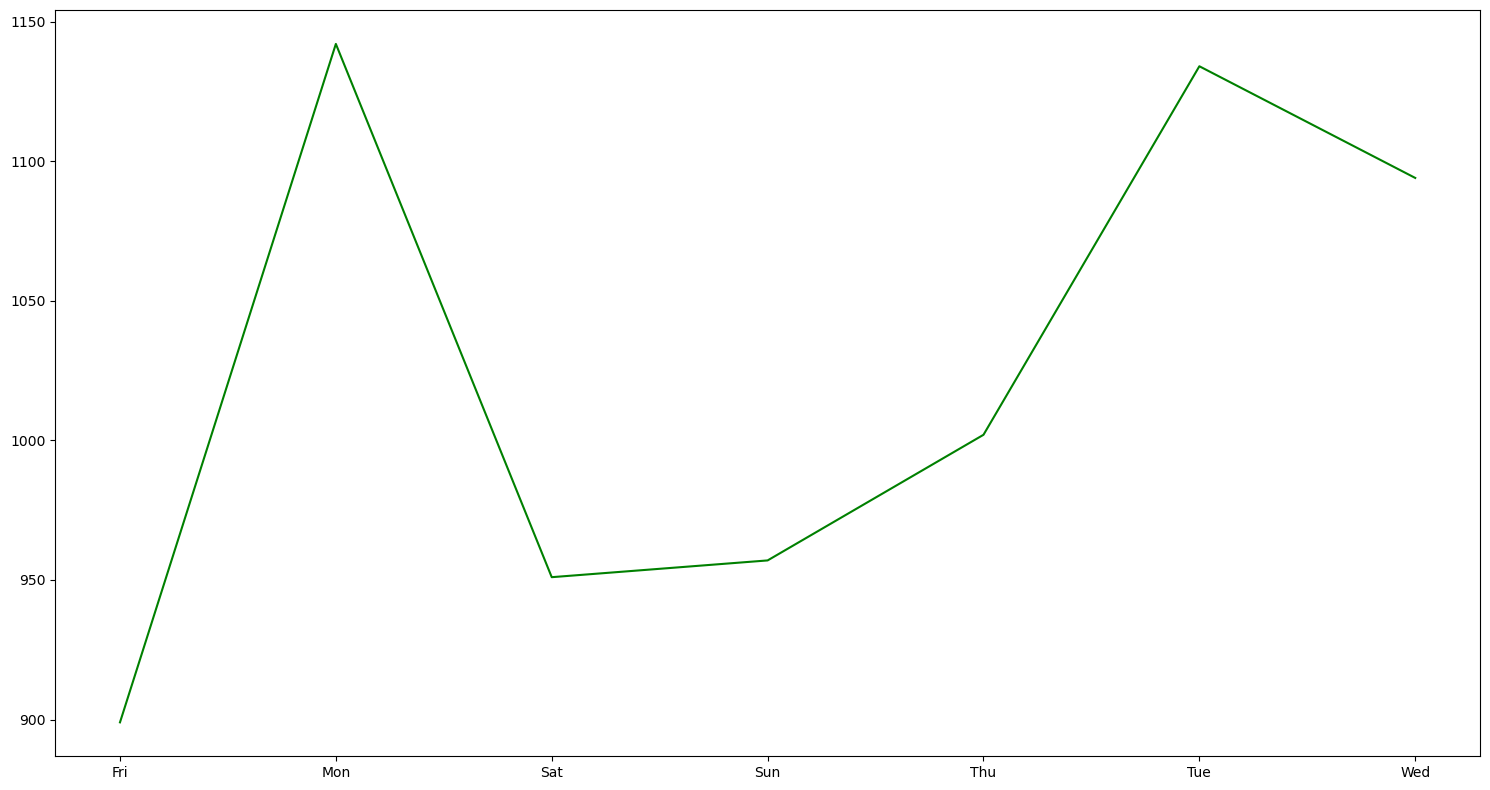

In [839]:
fig = plt.figure(figsize=(15,8))
plt.rcParams["figure.autolayout"] = True
#eixo = fig.add_axes([0, 0, 1, 1])
dfEiffelDistr=dfEiffelDate_info_data.groupby("diaSemana").count().sort("diaSemana").toPandas()
plt.plot(dfEiffelDistr["diaSemana"], dfEiffelDistr["count"], color= 'green')

eixo.set_title('Distribuição Temporal', fontsize=20)
eixo.set_ylabel('Revisões', fontsize=20)
eixo.set_xlabel('Data', fontsize=20)


https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/spark_session.html
http://maiconcunha.com/doc/preprocess_logs_nasa.html